### COP508 Machine Learning Coursework - Part 1: Training Pipeline

Student ID: F515605

Date: January 2026

### CODE ATTRIBUTION & SOURCES:
1. **TensorFlow/Keras Core Libraries:**
    - All model architectures from keras.applications module
    - Documentation: https://keras.io/api/applications/
    - Used: MobileNetV2, ResNet50V2, DenseNet121, Xception, EfficientNetB0

2. **Data Loading & Preprocessing:**
    - image_dataset_from_directory approach adapted from:
      * Lab 5 (Fashion MNIST)
      * TensorFlow documentation: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

3. **Data Augmentation:**
    - RandomFlip, RandomRotation, RandomZoom, RandomContrast layers from TensorFlow
    - Implementation based on Lab 5 materials
    - Adapted for 224x224 Sea Animals dataset

4. **Transfer Learning Strategy:**
    - Two-phase training (freeze base to fine-tune) adapted from:
      * TensorFlow transfer learning tutorial: https://www.tensorflow.org/tutorials/images/transfer_learning
      * Lab 6 materials

5. **Evaluation Metrics:**
    - classification_report, confusion_matrix, accuracy_score from scikit-learn
    - Documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

6. **Visualization:**
    - Matplotlib and seaborn for plotting (standard libraries)
    - Confusion matrix heatmaps based on seaborn documentation

7. **Original Contributions:**
    - Model architecture selection and hyperparameter tuning
    - Custom data augmentation parameters for Sea Animals dataset
    - Two-phase training implementation with specific learning rates
    - Comparative analysis across 6 different architectures

NO CODE WAS GENERATED BY AI TOOLS

All implementations written by me with reference to official documentation

### Importing Python Libraries

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import pathlib
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Data preprocessing pipeline
Data loading and splitting approach was adapted from COP508 lab 5 (Fashion MNIST Classification)

Tensor flow documentation: 
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

Modified to work with the Sea Animals dataset with (16 classes, 224x224 images)

### Setting the dataset path and image configuration

In [2]:
data_directory = pathlib.Path(r'C:\Users\Lenovo\OneDrive\Desktop\Loughborough\Machine Learning Sem 1\COP508_Sea_Animal_dataset\COP508_Sea_Animal_dataset') 

b_size = 32
image_height = 180
image_width = 180

### Loading the Dataset

In [3]:
print("Loading dataset...")
full_ds = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  seed=123,
  image_size=(image_height, image_width),
  batch_size=b_size,
  shuffle=True
)

total_class_names = full_ds.class_names
print(f"Found {len(total_class_names)} classes: {total_class_names}")

Loading dataset...
Found 8778 files belonging to 16 classes.
Found 16 classes: ['Corals', 'Crabs', 'Dolphin', 'Eel', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Puffers', 'Sea Rays', 'Seahorse', 'Seal', 'Sharks', 'Squid', 'Starfish', 'Whale']


### Visualization

We found 16 unique classes from the Sea animal dataset.

 Plotting the images...


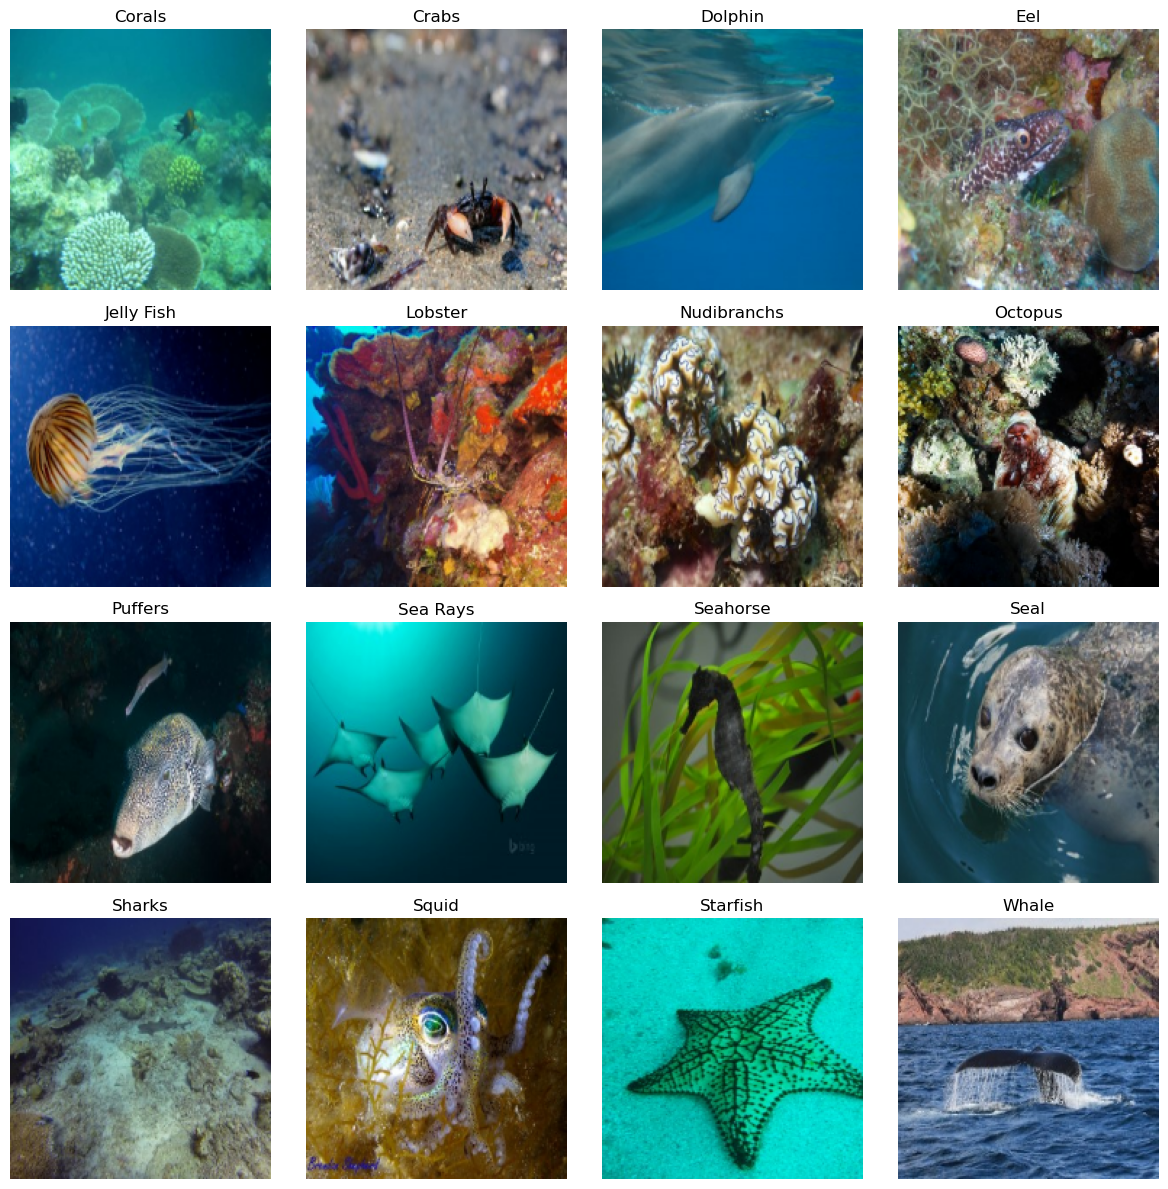

In [4]:
unique_imgs = {} # Creating a dictionary to store the class name and image data
target_count = len(total_class_names)

print("Collecting one example image for each class...")

# Collecting images from the sea animal dataset
# Looping through the entire dataset to ensure we get one image from each class 
for img, lab in full_ds:
    for i in range(len(img)):
        lab_index = lab[i].numpy()
        name = total_class_names[lab_index]
        
        # If we find a unique class, we save it
        if name not in unique_imgs:
            unique_imgs[name] = img[i].numpy().astype("uint8")
            
        # We stop once we have found all of the 16 image classes
        if len(unique_imgs) == target_count:
            break
    if len(unique_imgs) == target_count:
        break

# Sorting and Plotting the Images
print(f"We found {len(unique_imgs)} unique classes from the Sea animal dataset.")
print("\n Plotting the images...")
plt.figure(figsize=(12, 12))
sorted_labs = sorted(unique_imgs.keys()) # Sorting the images alphabetically

for idx, name in enumerate(sorted_labs):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(unique_imgs[name])
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Data Pre-processing

In [5]:
## Initially, we are splitting the dataset into (train-80% and val-20%)

print("\nCreating Data Splits...")
train_datas = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=b_size)

val_datas = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=b_size)

## Now we are further splitting the validation set into 2 equal halves (val-10%, test-10%)
validation_batches = tf.data.experimental.cardinality(val_datas)
test_datas = val_datas.take(validation_batches // 2)
val_datas = val_datas.skip(validation_batches // 2)

## Printing the number of batches for each training, validation, and testing
print(f"Training batches: {tf.data.experimental.cardinality(train_datas)}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_datas)}")
print(f"Test batches: {tf.data.experimental.cardinality(test_datas)}")

## Performing Data Augmentation
data_aug = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1),
])

## Performing Optimization
AUTOTUNE = tf.data.AUTOTUNE

train_datas = train_datas.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_datas = val_datas.cache().prefetch(buffer_size=AUTOTUNE)
test_datas = test_datas.cache().prefetch(buffer_size=AUTOTUNE)

print("Data Pre-processing step is complete. Data has been Split, Augmented, and Prefetched.")


Creating Data Splits...
Found 8778 files belonging to 16 classes.
Using 7023 files for training.
Found 8778 files belonging to 16 classes.
Using 1755 files for validation.
Training batches: 220
Validation batches: 28
Test batches: 27
Data Pre-processing step is complete. Data has been Split, Augmented, and Prefetched.



### DATA AUGMENTATION

Augmentation layers (RandomFlip, RandomRotation, RandomZoom) are based on: 

- TensorFlow Keras documentation: https://www.tensorflow.org/tutorials/images/classification

- COP508 Lab 5 Part A (Fashion MNIST)

Augmentation parameters tuned specifically for Sea Animals dataset


### We are building a custom CNN with Conv2D, Max pooling and Flatten

In [6]:
num_classes = len(total_class_names)

model = tf.keras.Sequential([
  # Step 1: Input & Pre-processing
  # We will specify the input shape over here so that the model can start building immediately
  tf.keras.layers.InputLayer(input_shape=(image_height, image_width, 3)),
  data_aug,
  tf.keras.layers.Rescaling(1./255), # Applying rescaling layer to normalize pixel intensity from [0 to 255] to [0 to 1]

  # Step 2: Convolutional Block 1, starting with 16 filters 
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  # Step 3: Convolutional Block 2, increasing the filters to 32 to combine previous edges
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  # Step 4: Convolutional Block 3, increasing filters to 64 to detect complex patterns
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  # Step 5: Regularization (To prevent overfitting, and relying too heavily on a single feature)
  tf.keras.layers.Dropout(0.2),

  # Step 6: Classification Head (Flattening 3D into 1D) 
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  
  # Final Output Layer
  tf.keras.layers.Dense(num_classes, name="outputs")
])

# Displaying the model architecture
model.summary()

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,990,704 (15.22 MB)

 Trainable params: 3,990,704 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Compilation and Training the model

In [8]:
print("Compiling the CNN model")
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training for 15 epochs to check
epochs = 30

print(f"Starting training for {epochs} epochs...")
history = model.fit(
  train_datas,
  validation_data=val_datas,
  epochs=epochs
)

Compiling the CNN model
Starting training for 30 epochs...
Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.2281 - loss: 2.3292 - val_accuracy: 0.2694 - val_loss: 2.2267
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - accuracy: 0.3024 - loss: 2.1020 - val_accuracy: 0.3232 - val_loss: 2.0721
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - accuracy: 0.3184 - loss: 2.0355 - val_accuracy: 0.3558 - val_loss: 1.9891
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - accuracy: 0.3348 - loss: 1.9860 - val_accuracy: 0.3580 - val_loss: 2.0084
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.3564 - loss: 1.9210 - val_accuracy: 0.3614 - val_loss: 1.9327
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - accuracy: 0.3715 - loss: 1.8825 - val_accuracy: 0.3816 - val_loss: 1.9329
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - accuracy: 0.3849 - loss: 1.8476 - val_accuracy: 0.4063 - val_loss: 1.8838
Epoch 8/30
220/220 ━━━━━

### Visualizing the training results

### TRAINING VISUALIZATION: Learning Curves

Plotting approach adapted from:
- COP508 Lab 5 Part A (Fashion MNIST)
- Matplotlib/Pandas plotting documentation

Shows training vs validation loss and accuracy over epochs


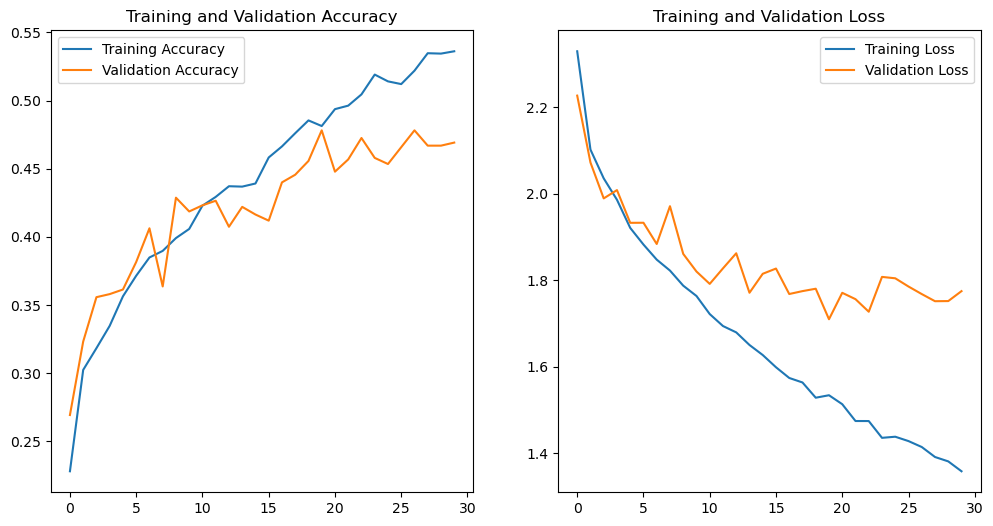

In [9]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

e_range = range(epochs)

plt.figure(figsize=(12, 6))

# Plotting Accuracy of CNN Model
plt.subplot(1, 2, 1)
plt.plot(e_range, accuracy, label='Training Accuracy')
plt.plot(e_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

# Plotting Loss of CNN Model
plt.subplot(1, 2, 2)
plt.plot(e_range, loss, label='Training Loss')
plt.plot(e_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Model Evaluation

### MODEL EVALUATION: Confusion Matrix & Classification Report

Evaluation metrics adapted from:
- scikit-learn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html
- COP508 Lab 3 & Lab 4 (model evaluation practices)
- seaborn heatmap: https://seaborn.pydata.org/generated/seaborn.heatmap.html

Confusion matrix visualizes per-class prediction accuracy


Classification report shows precision, recall, F1-score per class

Based on sklearn.metrics.classification_report documentation


Evaluating on Test Set
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4479 - loss: 1.7569

Final Test Accuracy: 44.79%
Final Test Loss: 1.7569
Generating predictions for the Confusion Matrix
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 

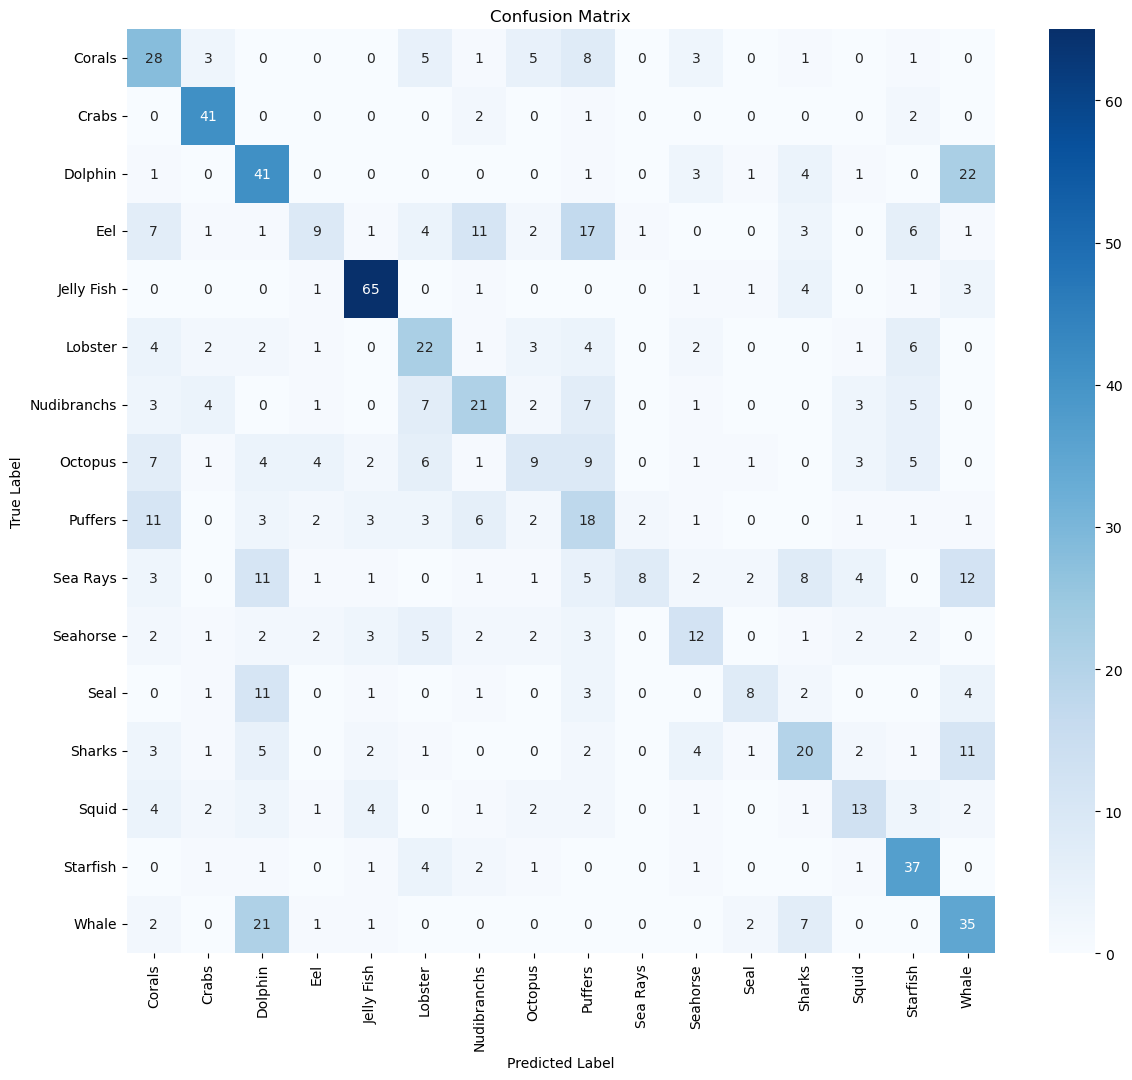


Classification Report:
              precision    recall  f1-score   support

      Corals       0.37      0.51      0.43        55
       Crabs       0.71      0.89      0.79        46
     Dolphin       0.39      0.55      0.46        74
         Eel       0.39      0.14      0.21        64
  Jelly Fish       0.77      0.84      0.81        77
     Lobster       0.39      0.46      0.42        48
 Nudibranchs       0.41      0.39      0.40        54
     Octopus       0.31      0.17      0.22        53
     Puffers       0.23      0.33      0.27        54
    Sea Rays       0.73      0.14      0.23        59
    Seahorse       0.38      0.31      0.34        39
        Seal       0.50      0.26      0.34        31
      Sharks       0.39      0.38      0.38        53
       Squid       0.42      0.33      0.37        39
    Starfish       0.53      0.76      0.62        49
       Whale       0.38      0.51      0.44        69

    accuracy                           0.45       864
  

In [12]:
## Evaluating model on test dataset
print("Evaluating on Test Set")
t_loss, t_accuracy = model.evaluate(test_datas)
print(f"\nFinal Test Accuracy: {t_accuracy:.2%}")
print(f"Final Test Loss: {t_loss:.4f}")

## Generating Confusion Matrix
a_true = []
a_predicted = []

print("Generating predictions for the Confusion Matrix")
for i, labs in test_datas:
    a_true.extend(labs.numpy())
    
    predictions = model.predict(i)
    predicted_labels = np.argmax(predictions, axis=1)
    a_predicted.extend(predicted_labels)

a_true = np.array(a_true)
a_predicted = np.array(a_predicted)

## Plotting the confusion Matrix
cm = confusion_matrix(a_true, a_predicted)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=total_class_names,
            yticklabels=total_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Printing the classification Report
print("\nClassification Report:")
print(classification_report(a_true, a_predicted, target_names=total_class_names))

## Saving the Model
model_save_path = 'CNN Model Sea Animals.keras'
model.save(model_save_path)

## Model Performance Update

The previous **CNN model** achieved a final **test accuracy of 44.79%**, which is below the desired performance threshold.  
To improve results, I will proceed with training an alternative classification approach.


### Transfer Learning Model using MobileNetV2 (This is a pretrained model)

### TRANSFER LEARNING: MobileNetV2
 
Transfer learning approach based on:
- TensorFlow transfer learning tutorial: https://www.tensorflow.org/tutorials/images/transfer_learning
- Keras Applications documentation: https://keras.io/api/applications/mobilenet/

Architecture: Pretrained MobileNetV2 (ImageNet weights) + custom classification head

Modifications: Custom dense layers, dropout, and batch normalization for 16-class problem

Two-phase training: (1) Freeze base, train head (2) Fine-tune top layers


In [28]:
## Downloading pre-trained base model

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(image_height, image_width, 3),
    include_top=False,
    weights='imagenet'
) ##include_top=False helps as cut off the classification head which was used for 1000 classes and weights='imagenet' loads the pre-learned weights

# We are freezing the base layers so that we do not destroy the already pre-trained layers of the model
base_model.trainable = False

# Building the final architecture of the Model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(image_height, image_width, 3)),
    
    # We have used data augmentation
    data_aug,
    
    # Pre-processing specific to MobileNetV2 (rescales -1 to 1)
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),
    
    base_model,
    
    # GlobalAveragePooling2D condenses the features
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dropout(0.2),
    
    # Our specific 16 classes
    tf.keras.layers.Dense(len(total_class_names), name="outputs") 
])

model.summary()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12656\49342292.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_3 (Lambda)                    │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 16)                  │          20,496 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,278,480 (8.69 MB)

 Trainable params: 20,496 (80.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Fine-Tuning

In [29]:
# PHASE 1: We have frozen the base layer and will be training on the dense layer only
print("\nPhase 1: Training Output Head")
base_lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

i_epochs = 20
history = model.fit(train_datas,
                    validation_data=val_datas,
                    epochs=i_epochs)

# PHASE 2: Now we will fine-tune the model, we will unfreeze the top layers of the base model 
print("\nPhase 2: Fine-Tuning Base Model")

base_model.trainable = True

# We are freezing the bottom 100 layers, so that we don't touch the foundations of the model 
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompiling with a much smaller learning rate so that we don't accidentally break the pre-trained knowledge
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_lr/10),
              metrics=['accuracy'])

ft_epochs = 30
t_epochs = i_epochs + ft_epochs

history_fine = model.fit(train_datas,
                         validation_data=val_datas,
                         initial_epoch=history.epoch[-1],
                         epochs=t_epochs)


Phase 1: Training Output Head
Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 263ms/step - accuracy: 0.2102 - loss: 2.6119 - val_accuracy: 0.4501 - val_loss: 1.8473
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 61s 278ms/step - accuracy: 0.4286 - loss: 1.8380 - val_accuracy: 0.5926 - val_loss: 1.3932
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 0.5069 - loss: 1.5286 - val_accuracy: 0.6667 - val_loss: 1.1858
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 58s 265ms/step - accuracy: 0.5690 - loss: 1.3607 - val_accuracy: 0.6914 - val_loss: 1.0791
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 0.5770 - loss: 1.2819 - val_accuracy: 0.7003 - val_loss: 1.0185
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 58s 265ms/step - accuracy: 0.6084 - loss: 1.2179 - val_accuracy: 0.7149 - val_loss: 0.9603
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 58s 265ms/step - accuracy: 0.6258 - loss: 1.1685 - val_accuracy: 0.7138 - val_loss: 0.9359
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 270ms/st

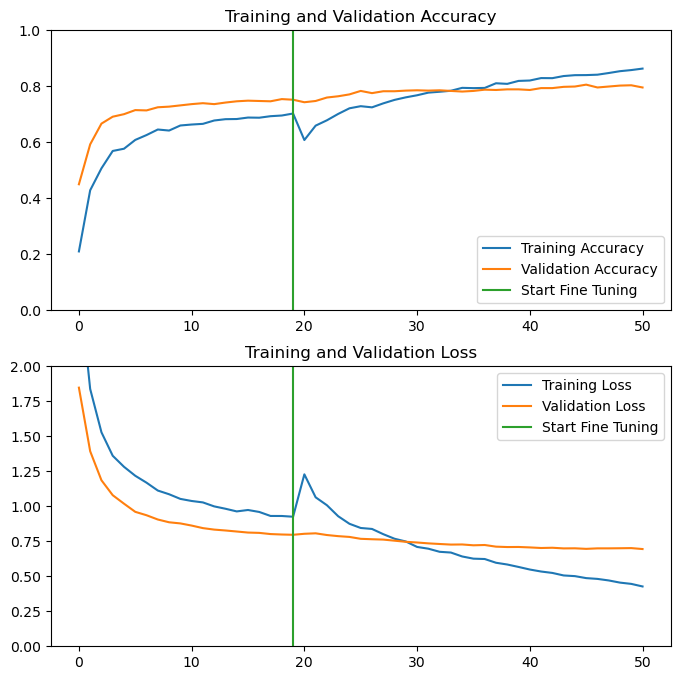

In [30]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Plotting
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([i_epochs-1,i_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0]) 
plt.plot([i_epochs-1,i_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluating on Test Set
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.8125 - loss: 0.6031

Final Test Accuracy: 81.25%
Final Test Loss: 0.6031
Generating predictions for the Confusion Matrix
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

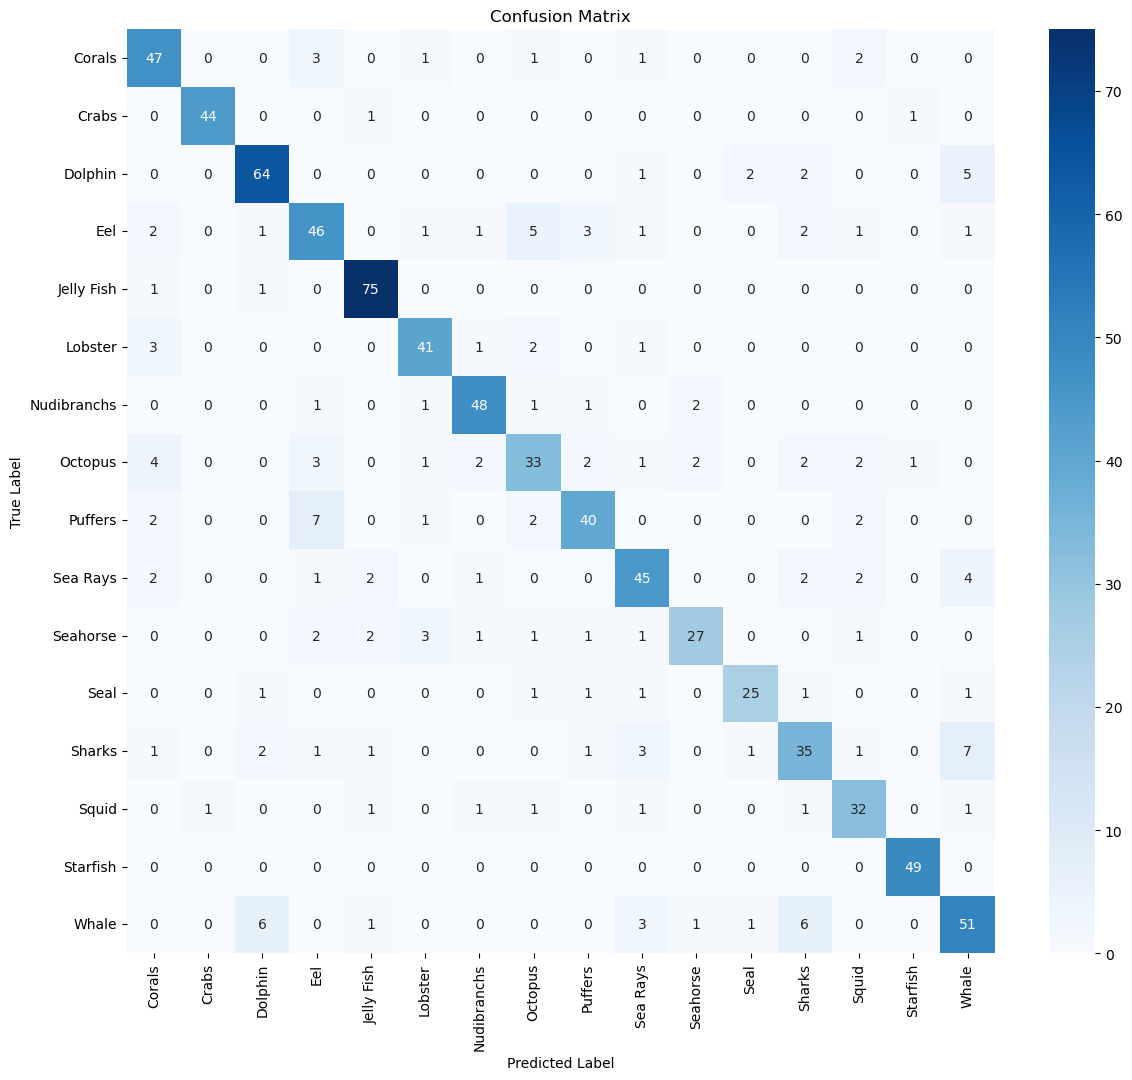


Classification Report:
              precision    recall  f1-score   support

      Corals       0.76      0.85      0.80        55
       Crabs       0.98      0.96      0.97        46
     Dolphin       0.85      0.86      0.86        74
         Eel       0.72      0.72      0.72        64
  Jelly Fish       0.90      0.97      0.94        77
     Lobster       0.84      0.85      0.85        48
 Nudibranchs       0.87      0.89      0.88        54
     Octopus       0.70      0.62      0.66        53
     Puffers       0.82      0.74      0.78        54
    Sea Rays       0.76      0.76      0.76        59
    Seahorse       0.84      0.69      0.76        39
        Seal       0.86      0.81      0.83        31
      Sharks       0.69      0.66      0.67        53
       Squid       0.74      0.82      0.78        39
    Starfish       0.96      1.00      0.98        49
       Whale       0.73      0.74      0.73        69

    accuracy                           0.81       864
  

In [31]:
## Evaluating model on test dataset
print("Evaluating on Test Set")
t_loss, t_accuracy = model.evaluate(test_datas)
print(f"\nFinal Test Accuracy: {t_accuracy:.2%}")
print(f"Final Test Loss: {t_loss:.4f}")

## Generating Confusion Matrix
a_true = []
a_predicted = []

print("Generating predictions for the Confusion Matrix")
for i, labs in test_datas:
    a_true.extend(labs.numpy())
    
    predictions = model.predict(i)
    predicted_labels = np.argmax(predictions, axis=1)
    a_predicted.extend(predicted_labels)

a_true = np.array(a_true)
a_predicted = np.array(a_predicted)

## Plotting the confusion Matrix
cm = confusion_matrix(a_true, a_predicted)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=total_class_names,
            yticklabels=total_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Printing the classification Report
print("\nClassification Report:")
print(classification_report(a_true, a_predicted, target_names=total_class_names))

## Saving the Model
model_save_path = 'MobileNetV2 Sea Animals.keras'
model.save(model_save_path)

### MobileNetV2 Results Summary

The **MobileNetV2** model achieved a good **Test Accuracy score of 81.25%**, it demonstartated effective **transfer learning** and got a good **generalization**, as the accuracy on test dataset exceeded the accuracy on validation dataset (79.57%). The two-phase fine-tuning approach was successful as it improved the performance from 76% to over 81%, with the validation loss reduced to **0.69**.

The model performed well on the distinct classes like **Starfish (F1: 0.98)**, **Jelly Fish (F1: 0.94)**, and **Crabs (F1: 0.97)**. However, it has struggled with the visually similar and camouflaged classes like **Sharks (F1: 0.67)** and **Octopus (Recall: 0.62)**

**Next Step:**  
Now we will test another architecture DenseNet121


### DenseNet121

### TRANSFER LEARNING: DenseNet121

Transfer learning approach based on:
- TensorFlow transfer learning tutorial: https://www.tensorflow.org/tutorials/images/transfer_learning
- Keras Applications documentation: https://keras.io/api/applications/densenet/

Architecture: Pretrained DenseNet121 (ImageNet weights) + custom classification head

Modifications: GlobalAveragePooling2D, batch normalization, dropout, and dense layers for 16-class problem

Two-phase training: (1) Freeze base, train head (2) Fine-tune top layers


In [32]:
## We are loading the pre-trained base model DenseNet121
base_model = tf.keras.applications.DenseNet121(
    include_top=False, #This cuts off the final classification head
    weights='imagenet', #Retaining the pre learned knowledge of the model instead of starting from scratch
    input_shape=(image_height, image_width, 3)
)

# We are freezing the base layers so that we do not destroy the already pre-trained layers of the model
base_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(image_height, image_width, 3)),
    
    # Performing data augmentation
    data_aug,
    
    # DenseNet preprocessing
    tf.keras.layers.Lambda(tf.keras.applications.densenet.preprocess_input),
    
    base_model,
    
    tf.keras.layers.GlobalAveragePooling2D(), #Converting 3D features into 1D
    tf.keras.layers.BatchNormalization(), # Added for stability 
    tf.keras.layers.Dropout(0.3), #Randomly turning 30% of the neurons off to prevent overfitting based on a specific feature
    tf.keras.layers.Dense(256, activation='relu'), #connects all the features seen in previous layers 
    tf.keras.layers.Dropout(0.2), #Randomly turning 20% of the neurons off to prevent overfitting based on a specific feature
    tf.keras.layers.Dense(len(total_class_names), name="outputs") #Output layer
])

model.summary()

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_4 (Lambda)                    │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 5, 5, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 16)                  │           4,112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,308,112 (27.88 MB)

 Trainable params: 268,560 (1.02 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

### TRAINING CALLBACKS

EarlyStopping and ReduceLROnPlateau callbacks adapted from:

- Lab 5 Part A in (Section 1.3 - Using Callbacks during Training)
- Keras documentation: https://keras.io/api/callbacks/

The Parameters patience and monitor were adjusted for this dataset


In [33]:
#compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callbacks = [
    # We will stop the model if the validation loss does not improve for 5 epochs
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    # We will lower the Learning Rate if it is stuck for 2 epochs
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2, min_lr=1e-6, monitor='val_loss')
]

print("Phase 1: Training Head (DenseNet)")
history = model.fit(train_datas,
                    validation_data=val_datas,
                    epochs=25, # It may stop early depending on the validation loss
                    callbacks=callbacks)

### Aggressive Fine Tuning

print("\nPhase 2: Unfreezing Entire Model")

# Now we will unfreeze all the layers of the model for maximum adaptation
base_model.trainable = True

#We are using a very small learning rate so as to not destroy the training weights
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

total_epochs = 50 

history_fine = model.fit(train_datas,
                         validation_data=val_datas,
                         initial_epoch=history.epoch[-1],
                         epochs=total_epochs,
                         callbacks=callbacks)

Phase 1: Training Head (DenseNet)
Epoch 1/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 202s 815ms/step - accuracy: 0.6013 - loss: 1.2806 - val_accuracy: 0.7565 - val_loss: 0.7399 - learning_rate: 0.0010
Epoch 2/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 163s 739ms/step - accuracy: 0.7011 - loss: 0.9263 - val_accuracy: 0.7879 - val_loss: 0.6672 - learning_rate: 0.0010
Epoch 3/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 163s 740ms/step - accuracy: 0.7273 - loss: 0.8391 - val_accuracy: 0.8070 - val_loss: 0.6424 - learning_rate: 0.0010
Epoch 4/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 163s 740ms/step - accuracy: 0.7497 - loss: 0.7835 - val_accuracy: 0.7969 - val_loss: 0.6545 - learning_rate: 0.0010
Epoch 5/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 161s 731ms/step - accuracy: 0.7574 - loss: 0.7435 - val_accuracy: 0.7991 - val_loss: 0.6520 - learning_rate: 0.0010
Epoch 6/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 160s 725ms/step - accuracy: 0.7804 - loss: 0.6702 - val_accuracy: 0.8182 - val_loss: 0.5988 - learning_rate: 2.0000e-04
Epoch 7/25
220/220 ━━━━━━━

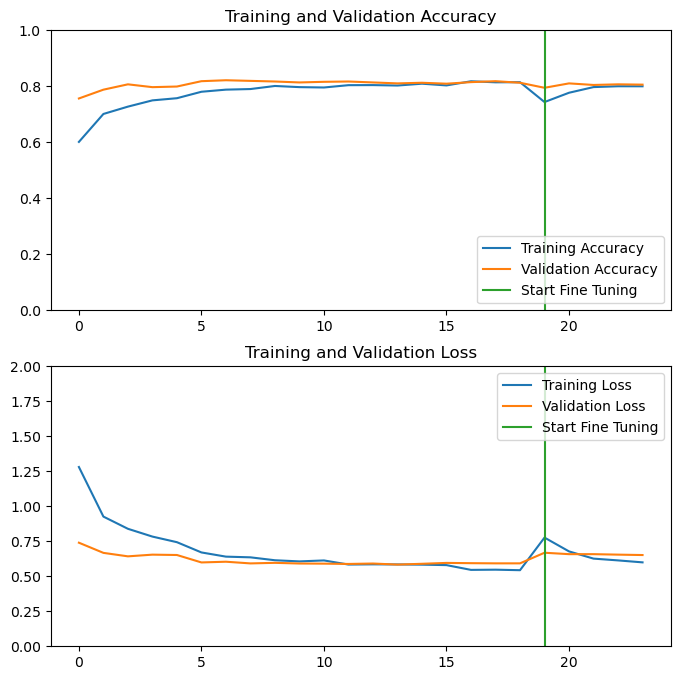

In [34]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Plotting
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([i_epochs-1,i_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0]) # Adjust max loss view if needed
plt.plot([i_epochs-1,i_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluating on Test Set
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8241 - loss: 0.6022

Final Test Accuracy: 82.41%
Final Test Loss: 0.6022
Generating predictions for the Confusion Matrix
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

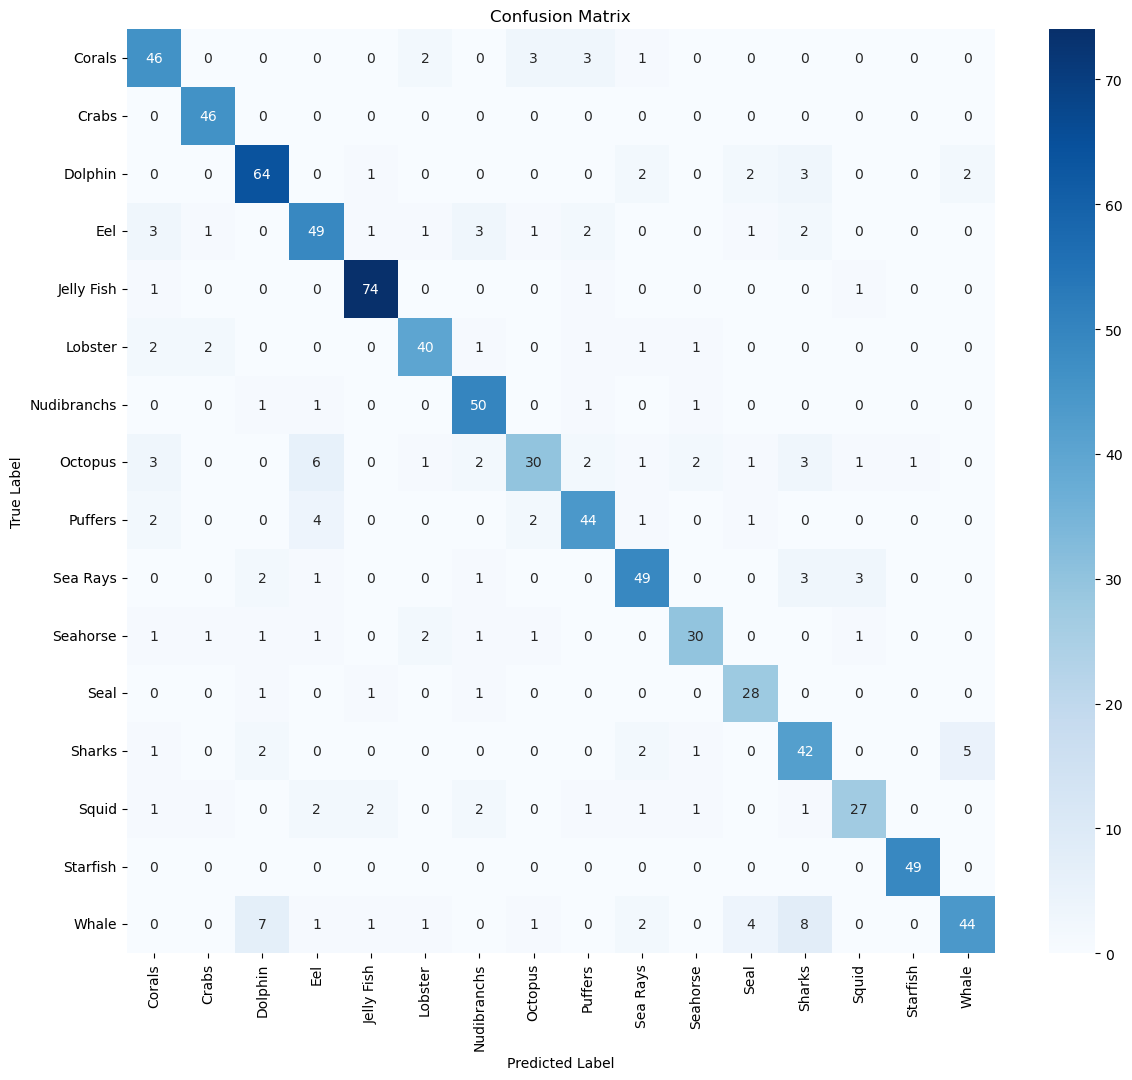


Classification Report:
              precision    recall  f1-score   support

      Corals       0.77      0.84      0.80        55
       Crabs       0.90      1.00      0.95        46
     Dolphin       0.82      0.86      0.84        74
         Eel       0.75      0.77      0.76        64
  Jelly Fish       0.93      0.96      0.94        77
     Lobster       0.85      0.83      0.84        48
 Nudibranchs       0.82      0.93      0.87        54
     Octopus       0.79      0.57      0.66        53
     Puffers       0.80      0.81      0.81        54
    Sea Rays       0.82      0.83      0.82        59
    Seahorse       0.83      0.77      0.80        39
        Seal       0.76      0.90      0.82        31
      Sharks       0.68      0.79      0.73        53
       Squid       0.82      0.69      0.75        39
    Starfish       0.98      1.00      0.99        49
       Whale       0.86      0.64      0.73        69

    accuracy                           0.82       864
  

In [35]:
## Evaluating model on test dataset
print("Evaluating on Test Set")
t_loss, t_accuracy = model.evaluate(test_datas)
print(f"\nFinal Test Accuracy: {t_accuracy:.2%}")
print(f"Final Test Loss: {t_loss:.4f}")

## Generating Confusion Matrix
a_true = []
a_predicted = []

print("Generating predictions for the Confusion Matrix")
for i, labs in test_datas:
    a_true.extend(labs.numpy())
    
    predictions = model.predict(i)
    predicted_labels = np.argmax(predictions, axis=1)
    a_predicted.extend(predicted_labels)

a_true = np.array(a_true)
a_predicted = np.array(a_predicted)

## Plotting the confusion Matrix
cm = confusion_matrix(a_true, a_predicted)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=total_class_names,
            yticklabels=total_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Printing the classification Report
print("\nClassification Report:")
print(classification_report(a_true, a_predicted, target_names=total_class_names))

## Saving the Model
model_save_path = 'DenseNet121 Sea Animals.keras'
model.save(model_save_path)

### Now we are increasing the image size to 224 to try with higher resolution

In [37]:
image_height = 224 
image_width = 224
b_size = 32

print("Reloading sea animals dataset at 224x224 resolution")

train_datas = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=b_size)

val_datas = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=b_size)

val_batches = tf.data.experimental.cardinality(val_datas)
test_datas = val_datas.take(val_batches // 2)
val_datas = val_datas.skip(val_batches // 2)

AUTOTUNE = tf.data.AUTOTUNE
train_datas = train_datas.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_datas = val_datas.cache().prefetch(buffer_size=AUTOTUNE)
test_datas = test_datas.cache().prefetch(buffer_size=AUTOTUNE)

print("Sea animals dataset has been reloaded at High Resolution.")

Reloading sea animals dataset at 224x224 resolution
Found 8778 files belonging to 16 classes.
Using 7023 files for training.
Found 8778 files belonging to 16 classes.
Using 1755 files for validation.
Sea animals dataset has been reloaded at High Resolution.


### Transfer Learning with Xception

### TRANSFER LEARNING: Xception

Transfer learning approach based on:
- TensorFlow transfer learning tutorial: https://www.tensorflow.org/tutorials/images/transfer_learning
- Keras Applications documentation: https://keras.io/api/applications/xception/

Architecture: Pretrained Xception (ImageNet weights) + custom classification head

Modifications: Data augmentation with RandomContrast, batch normalization, dropout for 16-class problem

Two-phase training: (1) Freeze base, train head (2) Fine-tune last 40 layers


In [38]:
## Loading the pre-trained Xception architecture
base_model = tf.keras.applications.Xception(
    input_shape=(image_height, image_width, 3),
    include_top=False, #This cuts off the final classification head
    weights='imagenet' #Retaining the pre learned knowledge of the model instead of starting from scratch
)
# We are freezing the base layers so that we do not destroy the already pre-trained layers of the model
base_model.trainable = False

#Performing data augmentation with contrast
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(image_height, image_width, 3)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2), 
    
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input), #Scaling 
    
    base_model,
    
    tf.keras.layers.GlobalAveragePooling2D(), #Converting 3D features into 1D
    tf.keras.layers.BatchNormalization(), #Added for stability
    tf.keras.layers.Dropout(0.4), #Randomly turning 40% of the neurons off to prevent overfitting based on a specific feature
    tf.keras.layers.Dense(len(total_class_names), name="outputs")
])

model.summary()

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_5 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 16)                  │          32,784 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,902,456 (79.74 MB)

 Trainable params: 36,880 (144.06 KB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [40]:
print("\nPhase 1:")
callback_p1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,                #3 epochs will be given for the model to recover accuracy
    restore_best_weights=True, #If the model fails at an epoch we will recover the best epoch
    verbose=1
)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_datas, validation_data=val_datas, epochs=15,callbacks=[callback_p1])
print(f"Phase 1 has been completed. The weights have been restored to the best epoch:{callback_p1.best_epoch +1}")

print("\nPhase 2: Fine-Tuning with Xception")
base_model.trainable = True

for layer in base_model.layers[:-40]:
    layer.trainable = False

## Defining the callback for Phase 2 
callbacks_p2 = [
    #If there will be no improvement until 6 epochs, we will fall back to the best epoch
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=6, 
        restore_best_weights=True, 
        verbose=1
    ),
    # If the model is stuck at an epoch, we will slow down the learning rate
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        patience=3, 
        factor=0.2, 
        min_lr=1e-7,
        verbose=1
    )
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_fine = model.fit(train_datas,
                         validation_data=val_datas,
                         initial_epoch=history.epoch[-1],
                         epochs=50,
                         callbacks=callbacks_p2)

print("High-Precision Training Complete.")


Phase 1:
Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.5754 - loss: 1.5114 - val_accuracy: 0.7677 - val_loss: 0.7548
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.6671 - loss: 1.1293 - val_accuracy: 0.7856 - val_loss: 0.7409
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.6886 - loss: 1.0618 - val_accuracy: 0.7778 - val_loss: 0.7810
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 568s 3s/step - accuracy: 0.7102 - loss: 1.0054 - val_accuracy: 0.7868 - val_loss: 0.7302
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.7040 - loss: 0.9887 - val_accuracy: 0.7901 - val_loss: 0.7351
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.7192 - loss: 0.9527 - val_accuracy: 0.7811 - val_loss: 0.7805
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.7151 - loss: 0.9278 - val_accuracy: 0.7733 - val_loss: 0.7527
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 588s 3s/step - accuracy: 0.7269 - loss: 0.9138 

In [45]:
target_test_set = test_datas

def tta_predict(model, dataset):
    y_t = []
    y_pp = []
    
    print("Predicting...", end="")
    for images, labels in dataset:
        y_t.extend(labels.numpy())
        
        # Standard
        pred = model.predict(images, verbose=0)
        # Flipped
        pred_flip = model.predict(tf.image.flip_left_right(images), verbose=0)
        
        y_pp.extend((pred + pred_flip)/2)
        
    print("Done.")
    return np.array(y_t), np.array(y_pp)

## aggregating predictions across multiple augmented views of each test image
y_t, y_probs = tta_predict(model, target_test_set)
## taking the highest probability score for each sample
y_predictions = np.argmax(y_probs, axis=1)

# calculating the final accuracy after tta
acc = accuracy_score(y_t, y_predictions)

print(f"\n Accuracy for model (Xception + TTA): {acc:.2%}")
print("\nClassification Report for Xception Model")
print(classification_report(y_t, y_predictions, target_names=total_class_names))

model.save('COP508_Xception.keras')

Predicting...Done.

 Accuracy for model (Xception + TTA): 84.95%

Classification Report for Xception Model
              precision    recall  f1-score   support

      Corals       0.81      0.84      0.82        55
       Crabs       0.96      0.98      0.97        46
     Dolphin       0.87      0.88      0.87        74
         Eel       0.82      0.84      0.83        64
  Jelly Fish       0.94      0.95      0.94        77
     Lobster       0.85      0.81      0.83        48
 Nudibranchs       0.86      0.93      0.89        54
     Octopus       0.76      0.66      0.71        53
     Puffers       0.91      0.91      0.91        54
    Sea Rays       0.77      0.81      0.79        59
    Seahorse       0.94      0.79      0.86        39
        Seal       0.88      0.94      0.91        31
      Sharks       0.74      0.79      0.76        53
       Squid       0.73      0.77      0.75        39
    Starfish       0.94      1.00      0.97        49
       Whale       0.83     


Standard Evaluation of Xception Model
Standard Accuracy for Xception model: 84.84%

TTA Evaluation for Xception Model (Image + Flip)
TTA Accuracy:      84.95%
Improvement:       +0.12%


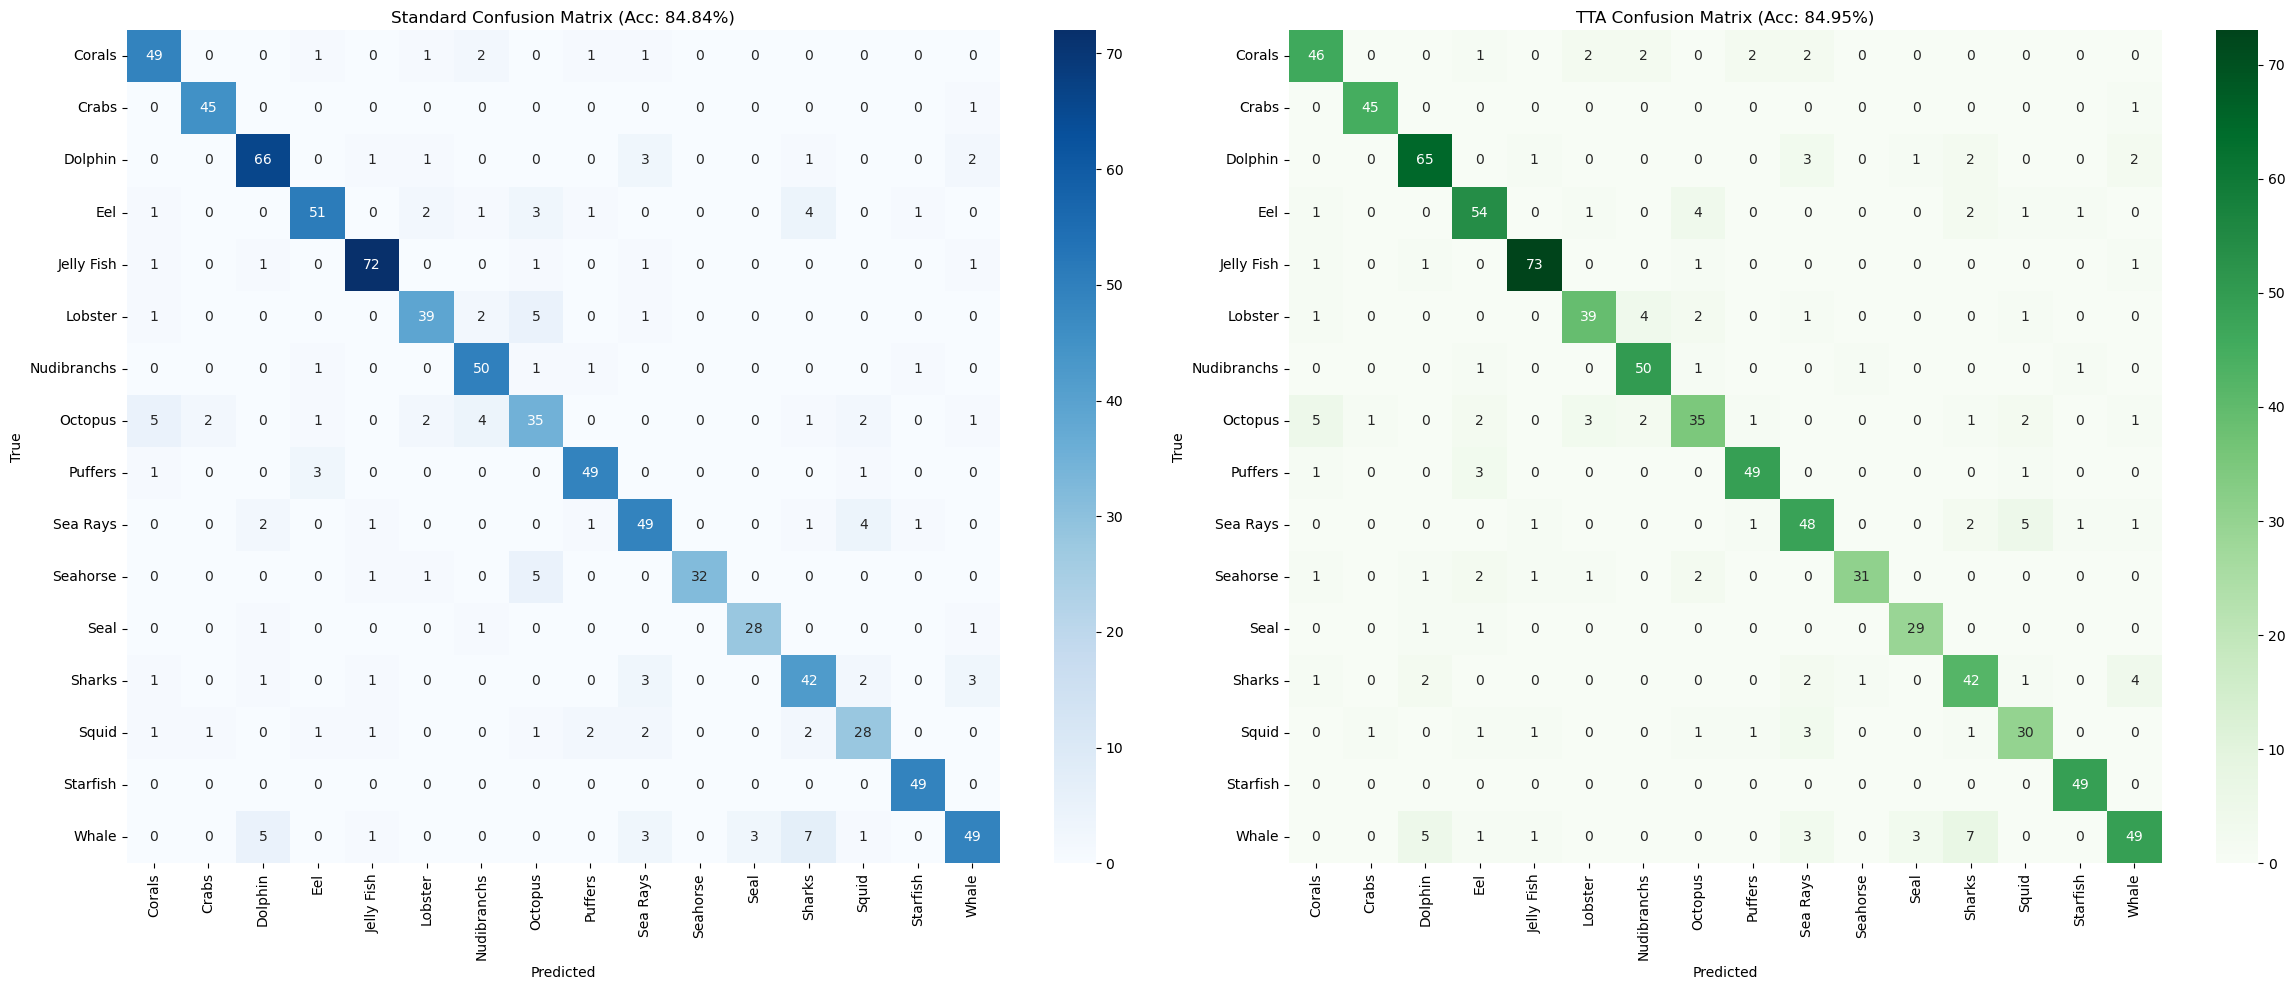

STANDARD CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Corals       0.82      0.89      0.85        55
       Crabs       0.94      0.98      0.96        46
     Dolphin       0.87      0.89      0.88        74
         Eel       0.88      0.80      0.84        64
  Jelly Fish       0.92      0.94      0.93        77
     Lobster       0.85      0.81      0.83        48
 Nudibranchs       0.83      0.93      0.88        54
     Octopus       0.69      0.66      0.67        53
     Puffers       0.89      0.91      0.90        54
    Sea Rays       0.78      0.83      0.80        59
    Seahorse       1.00      0.82      0.90        39
        Seal       0.90      0.90      0.90        31
      Sharks       0.72      0.79      0.76        53
       Squid       0.74      0.72      0.73        39
    Starfish       0.94      1.00      0.97        49
       Whale       0.84      0.71      0.77        69

    accuracy                           0.85      

In [46]:
print("\nStandard Evaluation of Xception Model")
y_t = []
y_ps = []

for i, l in test_datas:
    y_t.extend(l.numpy())
    # Standard prediction only
    predictions = model.predict(i, verbose=0)
    y_ps.extend(np.argmax(predictions, axis=1))

acc_standard = accuracy_score(y_t, y_ps)
print(f"Standard Accuracy for Xception model: {acc_standard:.2%}")

# TTA PREDICTION for Xception model
print("\nTTA Evaluation for Xception Model (Image + Flip)")
y_pred_tta = []

for i, l in test_datas:
    # Standard, predicting on the original image
    pred1 = model.predict(i, verbose=0)
    # Flipped, predicting on the flipped image
    pred2 = model.predict(tf.image.flip_left_right(i), verbose=0)
    # Average of the 2
    avg_pred = (pred1 + pred2) / 2
    y_pred_tta.extend(np.argmax(avg_pred, axis=1))

acc_tta = accuracy_score(y_t, y_pred_tta)
print(f"TTA Accuracy:      {acc_tta:.2%}")
print(f"Improvement:       {acc_tta - acc_standard:+.2%}")

# plotting side by side confusion matrices
class_names = getattr(test_datas, 'class_names', [str(i) for i in range(16)])

fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Standard Matrix
cm_std = confusion_matrix(y_t, y_ps)
sns.heatmap(cm_std, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=total_class_names, yticklabels=total_class_names)
axes[0].set_title(f'Standard Confusion Matrix (Acc: {acc_standard:.2%})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# TTA Matrix
cm_tta = confusion_matrix(y_t, y_pred_tta)
sns.heatmap(cm_tta, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=total_class_names, yticklabels=total_class_names)
axes[1].set_title(f'TTA Confusion Matrix (Acc: {acc_tta:.2%})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

print("STANDARD CLASSIFICATION REPORT")
print(classification_report(y_t, y_ps, target_names=total_class_names))

print("TTA CLASSIFICATION REPORT")
print(classification_report(y_t, y_pred_tta, target_names=total_class_names))

### RESNET

### TRANSFER LEARNING: ResNet50V2

Transfer learning approach based on:
- TensorFlow transfer learning tutorial: https://www.tensorflow.org/tutorials/images/transfer_learning
- Keras Applications documentation: https://keras.io/api/applications/resnet/

Architecture: Pretrained ResNet50V2 (ImageNet weights) + custom classification head

Modifications: RandomRotation, RandomContrast augmentation, dual dense layers with dropout for 16-class problem

Two-phase training: (1) Freeze base, train head (2) Fine-tune last 100 layers


In [47]:
## Loading the pre-trained ResNet architecture
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(image_height, image_width, 3),
    include_top=False, #This cuts off the final classification head
    weights='imagenet' #Retaining the pre learned knowledge of the model instead of starting from scratch

)
# We are freezing the base layers so that we do not destroy the already pre-trained layers of the model
base_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(image_height, image_width, 3)),

    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2), 
    tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input), # performing preprocessing Scaling
    
    base_model,
    
    tf.keras.layers.GlobalAveragePooling2D(), #Converting 3D features into 1D
    tf.keras.layers.BatchNormalization(), #Added for stability
    tf.keras.layers.Dropout(0.4), #Randomly turning 40% of the neurons off to prevent overfitting based on a specific feature
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dropout(0.2), #Randomly turning 20% of the neurons off to prevent overfitting based on a specific feature
    tf.keras.layers.Dense(len(class_names), name="outputs")
])

model.summary()

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_rotation_2 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_1 (RandomContrast)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_6 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 16)                  │           4,112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,101,648 (91.94 MB)

 Trainable params: 532,752 (2.03 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

In [48]:
print("\n Phase 1 for ResNet:")
callback_p1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3, #3 epochs will be given for the model to recover accuracy
    restore_best_weights=True, #If the model fails at an epoch we will recover the best epoch
    verbose=1
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_datas, validation_data=val_datas, epochs=15, callbacks=[callback_p1])

print(f"Phase 1 has been completed. The weights have been restored to the best epoch:{callback_p1.best_epoch +1}")

print("\nPhase 2: Fine-Tuning for ResNet")

base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

## Defining the callback for phase 2
callbacks_p2 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1), 
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-7, verbose=1)
] #If there will be no improvement until 6 epochs, we will fall back to the best epoch

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # If the model is stuck at an epoch, we will slow down the learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_fine = model.fit(
    train_datas,
    validation_data=val_datas,
    initial_epoch=history.epoch[-1],
    epochs=55,
    callbacks=callbacks_p2
)


 Phase 1 for ResNet:
Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 232s 989ms/step - accuracy: 0.6124 - loss: 1.3673 - val_accuracy: 0.7553 - val_loss: 0.7819
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 213s 971ms/step - accuracy: 0.7121 - loss: 0.9596 - val_accuracy: 0.7912 - val_loss: 0.7579
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 212s 963ms/step - accuracy: 0.7502 - loss: 0.8033 - val_accuracy: 0.7811 - val_loss: 0.7598
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 213s 967ms/step - accuracy: 0.7661 - loss: 0.7208 - val_accuracy: 0.7912 - val_loss: 0.7065
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 210s 955ms/step - accuracy: 0.7811 - loss: 0.6590 - val_accuracy: 0.8002 - val_loss: 0.7281
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 216s 983ms/step - accuracy: 0.7935 - loss: 0.6174 - val_accuracy: 0.7912 - val_loss: 0.7415
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 213s 967ms/step - accuracy: 0.8078 - loss: 0.5950 - val_accuracy: 0.7845 - val_loss: 0.7303
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 210s 956ms/ste

In [51]:
print("\n Running TTA Evaluation")

def tta_predict(model, dataset):
    y_true = []
    y_pred_probs = []
    
    print("Predicting on Test Dataset", end="")
    for images, labels in dataset:
        y_true.extend(labels.numpy())
        
        # Predicting on Standard Image
        pred = model.predict(images, verbose=0)
        # Predicting on Flipped Image
        pred_flip = model.predict(tf.image.flip_left_right(images), verbose=0)
        
        y_pred_probs.extend((pred + pred_flip)/2)
        
    print("Done")
    return np.array(y_true), np.array(y_pred_probs)

y_true, y_probs = tta_predict(model, test_datas)
y_preds = np.argmax(y_probs, axis=1)

acc = accuracy_score(y_true, y_preds)

print(f"\nResNet50V2 + TTA Accuracy: {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_true, y_preds, target_names=total_class_names))

model.save('COP508_ResNet_Final.keras')


 Running TTA Evaluation
Doneicting on Test Dataset

ResNet50V2 + TTA Accuracy: 84.26%

Classification Report:
              precision    recall  f1-score   support

      Corals       0.76      0.80      0.78        55
       Crabs       0.98      0.96      0.97        46
     Dolphin       0.87      0.91      0.89        74
         Eel       0.81      0.80      0.80        64
  Jelly Fish       0.96      0.94      0.95        77
     Lobster       0.88      0.79      0.84        48
 Nudibranchs       0.83      0.93      0.88        54
     Octopus       0.73      0.72      0.72        53
     Puffers       0.80      0.87      0.83        54
    Sea Rays       0.89      0.80      0.84        59
    Seahorse       0.76      0.87      0.81        39
        Seal       0.87      0.87      0.87        31
      Sharks       0.73      0.77      0.75        53
       Squid       0.76      0.74      0.75        39
    Starfish       1.00      0.98      0.99        49
       Whale       0.84 

### EfficientNetB0

# TRANSFER LEARNING: EfficientNetB0 (Final Model)

Transfer learning approach based on:
- TensorFlow transfer learning tutorial: https://www.tensorflow.org/tutorials/images/transfer_learning
- Keras Applications documentation: https://keras.io/api/applications/efficientnet/

Architecture: Pretrained EfficientNetB0 (ImageNet weights) + custom classification head

Modifications: RandomRotation augmentation, batch normalization, dropout for 16-class problem

Two-phase training: (1) Freeze base, train head (2) Fine-tune top 20 layers

BEST PERFORMANCE: 87.73% test accuracy with TTA (see Part_2 notebook)


In [52]:
print("\n Now we are building a new model with EfficientNetB0")

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, #This cuts off the final classification head
    weights='imagenet', #Retaining the pre learned knowledge of the model instead of starting from scratch
    input_shape=(image_height, image_width, 3)
)
# We are freezing the base layers so that we do not destroy the already pre-trained layers of the model
base_model.trainable = False 

inputs = tf.keras.Input(shape=(image_height, image_width, 3))
x = data_aug(inputs) 
x = tf.keras.applications.efficientnet.preprocess_input(x) # performing preprocessing Scaling
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x) #Converting 3D features into 1D
x = tf.keras.layers.BatchNormalization()(x) #Added for stability
x = tf.keras.layers.Dropout(0.3)(x) #Randomly turning 30% of the neurons off to prevent overfitting based on a specific feature
outputs = tf.keras.layers.Dense(len(class_names))(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


 Now we are building a new model with EfficientNetB0


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │          20,496 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,075,187 (15.55 MB)

 Trainable params: 23,056 (90.06 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [53]:
print("\n Starting Phase 1 of the model")

callback_p1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3, #3 epochs will be given for the model to recover accuracy
    restore_best_weights=True, #If the model fails at an epoch we will recover the best epoch
    verbose=1
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_datas, 
    validation_data=val_datas, 
    epochs=15, 
    callbacks=[callback_p1]
)

print(f"Phase 1 of EfficientNet has been completed. Model restored to Epoch {callback_p1.best_epoch + 1}")

print("\nStarting Phase 2: with Fine Tuning")

base_model.trainable = True

for layer in base_model.layers[:20]:
    layer.trainable = False

## Defining the callback for phase 2
callbacks_p2 = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=6, 
        restore_best_weights=True, 
        verbose=1
    ), #If there will be no improvement until 6 epochs, we will fall back to the best epoch
    # If the model is stuck at an epoch, we will slow down the learning rate
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        patience=3, 
        factor=0.2, 
        min_lr=1e-7, 
        verbose=1
    )
]

# Recompile with TINY learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train (Epochs set to 50, but will stop early)
history_fine = model.fit(
    train_datas,
    validation_data=val_datas,
    initial_epoch=history.epoch[-1],
    epochs=50,
    callbacks=callbacks_p2
)


 Starting Phase 1 of the model
Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 177s 691ms/step - accuracy: 0.6264 - loss: 1.2743 - val_accuracy: 0.7912 - val_loss: 0.6641
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 151s 685ms/step - accuracy: 0.7500 - loss: 0.8175 - val_accuracy: 0.8070 - val_loss: 0.5649
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 152s 692ms/step - accuracy: 0.7767 - loss: 0.7124 - val_accuracy: 0.8238 - val_loss: 0.5476
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 153s 695ms/step - accuracy: 0.7981 - loss: 0.6572 - val_accuracy: 0.8238 - val_loss: 0.5595
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 156s 708ms/step - accuracy: 0.7975 - loss: 0.6232 - val_accuracy: 0.8260 - val_loss: 0.5550
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 157s 714ms/step - accuracy: 0.8152 - loss: 0.5825 - val_accuracy: 0.8373 - val_loss: 0.5516
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 157s 716ms/step - accuracy: 0.8129 - loss: 0.5711 - val_accuracy: 0.8316 - val_loss: 0.5497
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 162s

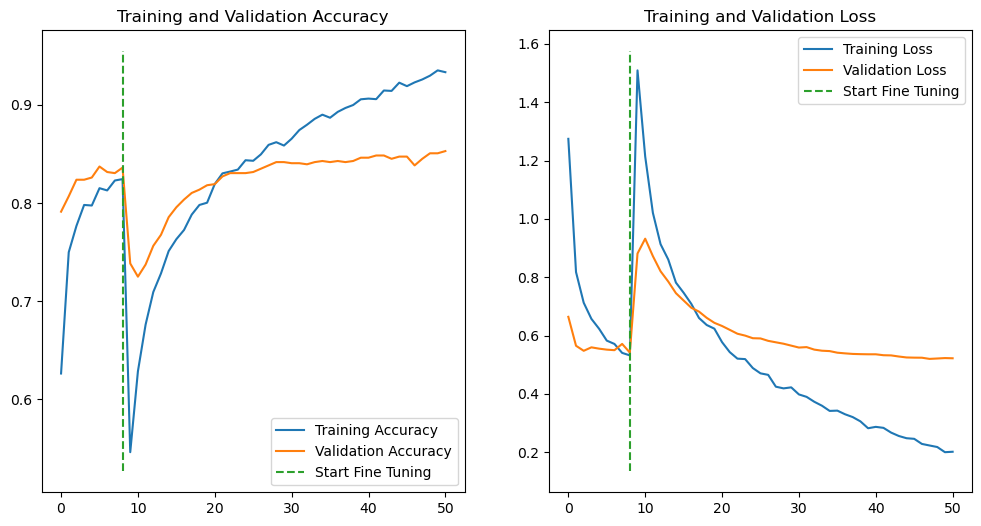

In [56]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([len(history.history['accuracy'])-1, len(history.history['accuracy'])-1],
          plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([len(history.history['accuracy'])-1, len(history.history['accuracy'])-1],
         plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


model.save('COP508_EfficientNetB0.keras')